# Lightweight Fine-Tuning Project

Below I list the PEFT technique, the model, evaluation approach and fine-tunning dataset I'll be using to fine tune the LLM
* PEFT technique: LoRA
* Model: Llama 3.1 8B
* Evaluation approach: Hugging Face Trainer.evaluate
* Fine-tuning dataset: [AuthorMix](https://huggingface.co/datasets/hallisky/AuthorMix)

## Loading and Evaluating a Foundation Model

Loading Llama 3.1 8B model and evaluate its performance prior to fine-tuning. This includes loading an appropriate tokenizer and dataset.

## Load in IMDB Dataset

In [ ]:
# Install dependencies
!pip install -q "datasets>=2.16.1"
!pip install torch
!pip install transformers
!pip install python-dotenv

In [1]:
from datasets import load_dataset

# Load the train and test splits of the imdb dataset
splits = ["train", "test"]
ds = {
    split: ds for split,
    ds in zip(splits, load_dataset("hallisky/AuthorMix", split=splits))
}

# Thin out the dataset to make it run faster for this example
for split in splits:
    ds[split] = ds[split].shuffle(seed=42).select(range(100))

# Show the dataset
ds

{'train': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 100
 }),
 'test': Dataset({
     features: ['style', 'text', 'category'],
     num_rows: 100
 })}

### Dataset Exploration

In [2]:
import pandas as pd

train_df = pd.DataFrame(ds['train'])

print(train_df.head())

       style                                               text category
0  blog11518  "Jamaia....come and help me talk some sense in...     blog
1  blog25872  I decided I wasn't going to go to Boler today....     blog
2      obama  For over two decades, bin Laden has been al Qa...   speech
3  blog11518  motion with precise timing. Sucking the cigare...     blog
4  blog11518  "So what, we just stand here?" Alyx prompts, h...     blog


The dataset contains 14 unique authors

In [3]:
unique_styles = train_df['style'].unique()
print(unique_styles)

['blog11518' 'blog25872' 'obama' 'fitzgerald' 'hemingway' 'woolf' 'bush'
 'blog30102' 'blog5546' 'trump' 'blog30407']


In 4 number of formats/categories

In [4]:
unique_formats = train_df['category'].unique()
print(unique_formats)

['blog' 'speech' 'author']


Dataset sample text length just skew towards 335 characters or less 

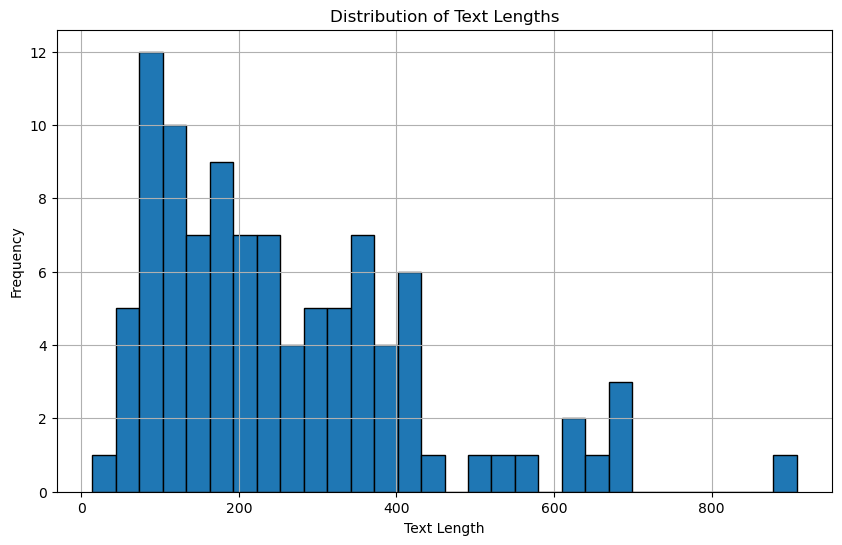

In [5]:
import matplotlib.pyplot as plt

train_df['text_length'] = train_df['text'].str.len()
plt.figure(figsize=(10, 6))
plt.hist(train_df['text_length'], bins=30, edgecolor='black')
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Intial Llama 3.1 8B evaluation on the dataset
Going to load in the Llama model through AutoModelForSequenceClassification and set the label ids

In [6]:
import torch
import os
from dotenv import load_dotenv
from huggingface_hub import login

load_dotenv("env.txt")
hf_token = os.getenv('HF_API_TOKEN')
login(hf_token)

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /Users/david/.cache/huggingface/token
Login successful


In [51]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification

num_labels = len(unique_styles)
id2label = {i: style for i, style in enumerate(unique_styles)}
label2id = {v: k for k, v in id2label.items()}
print(f"num_labels: {num_labels}")
print(f"id2label: {id2label}")
print(f"label2id: {label2id}")
# model_key = "meta-llama/Meta-Llama-3.1-8B"
model_key = "openai-community/gpt2"
model = AutoModelForSequenceClassification.from_pretrained(
    model_key,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    token=True,
)

num_labels: 11
id2label: {0: 'blog11518', 1: 'blog25872', 2: 'obama', 3: 'fitzgerald', 4: 'hemingway', 5: 'woolf', 6: 'bush', 7: 'blog30102', 8: 'blog5546', 9: 'trump', 10: 'blog30407'}
label2id: {'blog11518': 0, 'blog25872': 1, 'obama': 2, 'fitzgerald': 3, 'hemingway': 4, 'woolf': 5, 'bush': 6, 'blog30102': 7, 'blog5546': 8, 'trump': 9, 'blog30407': 10}


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at openai-community/gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
# Tokenizer setup
tokenizer = AutoTokenizer.from_pretrained(model_key, token=True)
tokenizer.pad_token = tokenizer.eos_token

In [53]:
def get_prediction(text):

    # Tokenize the text
    # (Get the response as tensors and not as a list)
    inputs = tokenizer(text, return_tensors="pt")

    # Perform the prediction (get the logits)
    outputs = model(**inputs)

    # Get the logits
    logits = outputs.logits
    
    # Apply softmax to the logits to get probabilities
    probabilities = torch.softmax(logits, dim=-1)
    
    # Get the predicted class (corresponding to the highest logit)
    predicted_class = torch.argmax(logits, dim=-1)
    
    return predicted_class, probabilities

In [54]:
ds['test'][15]

{'style': 'woolf',
 'text': '"It\'s his way of making friends, I suppose," she laughed. "Well--I shall do my part. I shall begin--\'Ugly in body, repulsive in mind as you are, Mr. Hirst--\'"',
 'category': 'author'}

In [55]:
prediction = get_prediction(ds['test'][15]['text'])
prediction

(tensor([7]),
 tensor([[1.6710e-03, 1.5877e-02, 5.3621e-04, 1.6320e-04, 1.1237e-03, 2.8860e-04,
          2.6345e-01, 7.1476e-01, 4.6898e-04, 3.0755e-04, 1.3558e-03]],
        grad_fn=<SoftmaxBackward0>))

In [56]:
def evaluate_model(dataset, model, tokenizer, n=None):
    correct_predictions = 0
    total_predictions = 0

    # If n is None, evaluate the whole dataset
    n = len(dataset['test']) if n is None else n
    
    # Loop over the dataset up to n rows
    for i in range(n):
        # Get the input text and true label from the dataset
        text = dataset['test'][i]['text']
        true_label = dataset['test'][i]['style']  # Assuming 'style' is the label field
        
        # Get the model's prediction and probabilities
        predicted_class, _ = get_prediction(text)
        
        # Check if the prediction is correct
        if predicted_class.item() == label2id[true_label]:  # Convert tensor to scalar with .item()
            correct_predictions += 1
        
        total_predictions += 1
    
    # Calculate the accuracy
    accuracy = correct_predictions / total_predictions * 100
    print(f"Accuracy: {accuracy:.2f}% ({correct_predictions}/{total_predictions})")
    
    return accuracy

evaluate_model(ds, model, tokenizer, n=5)

Accuracy: 0.00% (0/5)


0.0

### Preprocess dataset

In [27]:
from datasets import DatasetDict

# Preprocessing function
def preprocess_function(examples):
    tokens = tokenizer(examples['text'], truncation=True, padding='max_length', max_length=1600) #longest character count in dataset is about 1,550 characters, hints the max length
    tokens['label'] = [label2id.get(style, -1) for style in examples['style']]
    return tokens
    
# Tokenize the dataset
tokenized_ds = DatasetDict()
for split in splits:
    tokenized_ds[split] = ds[split].map(preprocess_function, batched=True)

model.resize_token_embeddings(len(tokenizer))

# Ensure the tokenized dataset is converted to PyTorch tensors
tokenized_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Directly access the batched inputs from the dataset
inputs = {
    'input_ids': tokenized_ds['test']['input_ids'],
    'attention_mask': tokenized_ds['test']['attention_mask'],
    'labels': tokenized_ds['test']['label']
}


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [28]:
# Move inputs to device (if using GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=11, bias=False)
)

In [29]:
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

AssertionError: Cannot handle batch sizes > 1 if no padding token is defined.